In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
train = pd.read_csv("datasets/test.csv")
sub = pd.read_csv("datasets/submission.csv")

In [3]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

train['İL'] = train['İL'].apply(unidecode).str.lower()
train['İLÇE'] = train['İLÇE'].apply(unidecode).str.lower()

train=pd.merge(train,ilce_nufus,on=['İLÇE'],how='left')

In [4]:
train["ilce_nufus"] = train["ilce_nufus"].astype(float)

In [5]:
train["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
train["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)

In [6]:
train["baslama_hour"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
train["baslama_day"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
train["baslama_dayofweek"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["baslama_dayofyear"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
train["baslama_month"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.month


train["bitis_hour"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
train["bitis_day"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
train["bitis_dayofweek"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["bitis_dayofyear"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week
train["bitis_month"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.month

C:\Users\talha\AppData\Local\Temp\ipykernel_13604\747259581.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_13604\747259581.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week


In [7]:
train.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)
train.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)
train.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)
train.drop("OutageID",axis=1,inplace=True)
train.drop("KESİNTİ_NO",axis=1, inplace=True)
train.drop("İLÇE", axis=1, inplace=True)
train.drop("KADEME",axis=1,inplace=True)

In [14]:
for i in train.columns:
    if "KESİNTİ_NEDENİNE" in i:
        print(i)

KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Atlama Kopuğu
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Box / Sdk Abone Çıkış Faz Sigorta Atığı
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Box / Sdk Abone Çıkış Sigorta Atığı
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Box / Sdk Giriş Faz Sigorta Atığı
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Box / Sdk Giriş Sigorta Atığı
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Box Arızası
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Branşman Yeraltı Kablo Arızası
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Direk Değişimi
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Direk Kırılması
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Direkten Kesme Açma
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Hatta Ağaç Kesimi
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Hatta Yabancı Cisim
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Havai Branşman Arızası
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Kablo Başlığı Arızası
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Kademe Ayarı
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Klemens Arızası
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA_AG Nötr İletke

In [8]:
train = pd.get_dummies(train,drop_first=True)

In [17]:
#train["NEW_KESİNTİ_NEDENİNE_1"] = 0
#train["NEW_KESİNTİ_NEDENİNE_2"] = 0

In [11]:
train.drop("SEBEBE_GÖRE_0", axis=1, inplace=True)

In [18]:
model = joblib.load("kesinti_lgbm_model.pkl")
preds = model.predict(train)

In [19]:
preds = pd.Series(preds)
preds = preds.apply(lambda x  : 0  if x < 0 else x)

In [20]:
sub["cagri_count"] = preds
sub["cagri_count"] = round(sub["cagri_count"])

In [21]:
sub.to_csv("submission.csv",index=False)

In [22]:
import matplotlib.pyplot as plt

<AxesSubplot:>

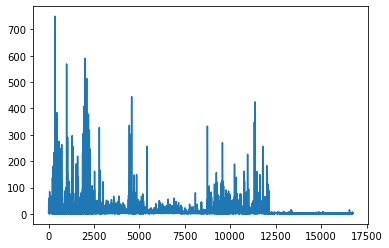

In [83]:
sub["cagri_count"].plot()

<AxesSubplot:>

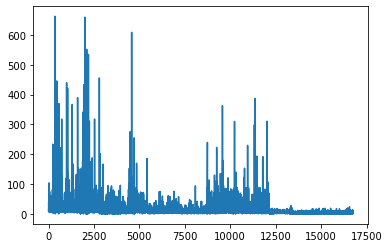

In [23]:
sub["cagri_count"].plot()

<AxesSubplot:>

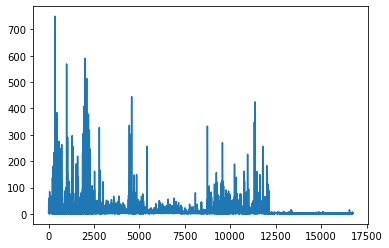

In [84]:
sub["cagri_count"].plot()

<AxesSubplot:>

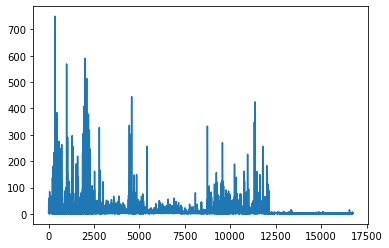

In [85]:
sub["cagri_count"].plot()